# IFRS 9 ECL Project - Data Loading & Exploration

**Author:** [Sebastian Gonzalez]  
**Date:** January 2025  

## Project Context

This notebook is part of a multi-step project to demonstrate an **IFRS 9** approach to credit risk using a publicly available **Credit Risk Dataset**.  
I'll ultimately show how to calculate **Expected Credit Loss (ECL)**, relying on:
1. **Probability of Default (PD)** modeling with machine learning.
2. **Loss Given Default (LGD)** assumption or derivation.
3. **Exposure at Default (EAD)** from the loan amount.
4. A simplified **macro scenario** to illustrate forward-looking requirements.

### Goals of this Notebook
1. **Load** the CSV (`credit_risk_dataset.csv`) from the `data/` folder.
2. **Inspect** columns, data types, and missing values.
3. **Conduct** a brief exploratory analysis (EDA), e.g., basic distributions.
4. **Plan** how to handle any data cleaning or feature transformations for IFRS 9 calculations.


## Exploratory Data Analysis (EDA) & Data Validation

### Dataset Overview

Below, I load the credit risk dataset and do some immediate checks: shape, head, and data types. This helps me confirm the dataset structure and see if everything the expected columns for this project.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualizations
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Adjust display setting
pd.set_option('display.max_columns', 30)

# Load dataset
df = pd.read_csv("../data/credit_risk_dataset.csv")

# Basic checks
print('Data shape:', df.shape)
print('\nFirst 5 rows:')
display(df.head())
print('\nData types:')
print(df.dtypes)

Data shape: (32581, 12)

First 5 rows:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4



Data types:
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object


**Observations:**
- The dataset has `df.shape[0]` rows and `df.shape[1]` columns (as shown above).
- Columns like `person_age`, `person_income`, and `loan_amnt` appear numeric.
- The `loan_status` column (0=non-default, 1=default) is my target for Probability of Default (PD) modeling.
- We see some float columns like `person_emp_length`, `loan_int_rate` with potential missing values (to be checked next).

### Missing Values

In credit risk analysis, we must handle missing values carefully, especially if they affect key fields like loan amount or interest rate.

In [30]:
missing_counts = df.isnull().sum().sort_values(ascending=False)
print('Missing values per column:\n', missing_counts)

Missing values per column:
 loan_int_rate                 3116
person_emp_length              895
person_age                       0
person_income                    0
person_home_ownership            0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


**Missing values observations:**
- `person_emp_length` has about 895 missing values.
- `loan_int_rate` has around 3116 missing values.
- Other columns have zero or negligible nulls.

Possible approaches:
- **`person_emp_length`**: We might impute with median or set to 0 for missing.
- **`loan_int_rate`**: Because interest rate is a key driver of risk, I could drop those rows if they're not too large a portion, or attempt an imputation model.
- I'll finalize the approach in a subsequent notebook or once I see how these features impact PD modeling.

### Target Variable Exploration

`loan_status` indicates whether the loan defaulted (1) or not (0).

#### Plot Target Distribution

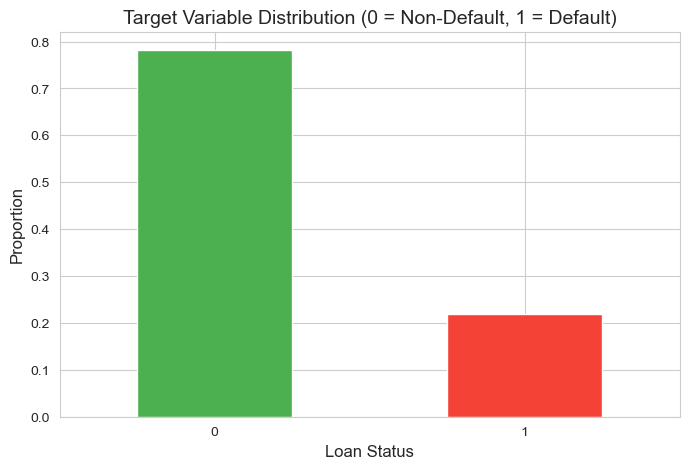

In [36]:
## Class Distribution (Default vs Non-Default)

# plot
plt.figure(figsize=(8, 5))
df['loan_status'].value_counts(normalize=True).plot(
    kind = "bar", color=["#4CAF50", "#F44336"]
)
plt.title("Target Variable Distribution (0 = Non-Default, 1 = Default)", fontsize=14)
plt.xlabel("Loan Status", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.xticks(rotation=0)
plt.show()

**Interpretation:**
- The majority of loans are non-default (around 80%), and 20% are default.
- This class imbalance is typical in real credit datasets.

This imbalance is crucial for IFRS 9, as I need robust modeling even for a minority class of defaults.

### Numeric Distributions

I'll visualize key numeric columns (e.g., `person_age`, `person_income`, `loan_amnt`, `loan_int_rate`, etc.) to understand their distribution and potential outliers.

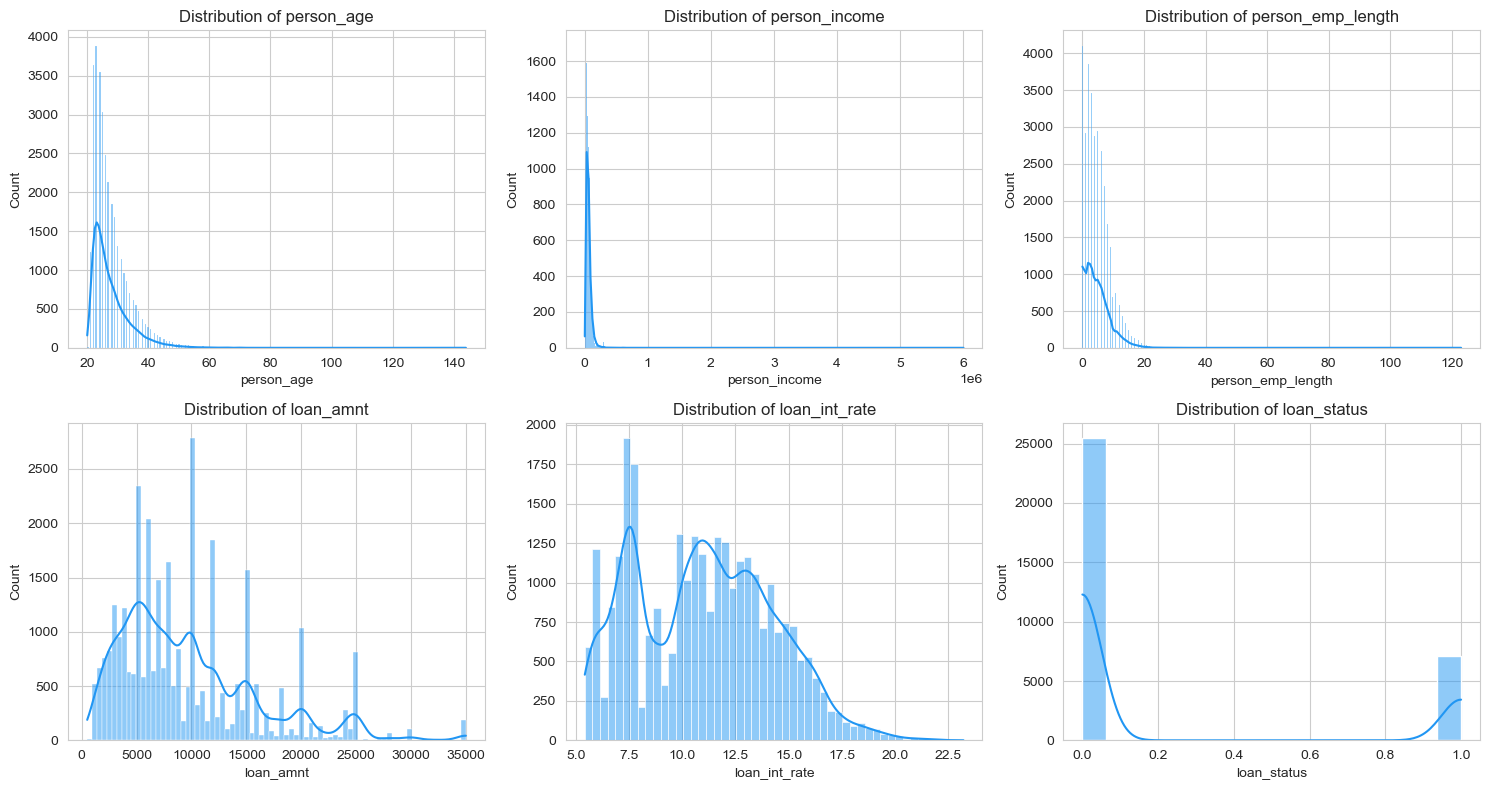

In [42]:
#display(df.describe(include='all'))

# quick numeric distribution
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols = list(numeric_cols) # turn into a list for easy iteration

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axs = axs.flatten()

for i, col in enumerate(numeric_cols[:6]): 
    sns.histplot(data=df, x=col, kde=True, ax=axs[i], color='#2196F3')
    axs[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

**Interpreation of Key Distributions:**

- `person_age`, `person_income`, and `person_emp_length` are right-skewed (many low values, few very high).
- `loan_amnt` has a range from about 500 to 35,000 with a peak around 10k-12k.
- `loan_int_rate` mostly between 5% and 20%, with a peak around 10%-12%

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581,31686.000000,32581,32581,32581.000000,29465.000000,32581.000000,32581.000000,32581,32581.000000
unique,NaN,NaN,4,NaN,6,7,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,RENT,NaN,EDUCATION,A,NaN,NaN,NaN,NaN,N,NaN
freq,NaN,NaN,16446,NaN,6453,10777,NaN,NaN,NaN,NaN,26836,NaN
mean,27.734600,6.607485e+04,NaN,4.789686,NaN,NaN,9589.371106,11.011695,0.218164,0.170203,NaN,5.804211
std,6.348078,6.198312e+04,NaN,4.142630,NaN,NaN,6322.086646,3.240459,0.413006,0.106782,NaN,4.055001
min,20.000000,4.000000e+03,NaN,0.000000,NaN,NaN,500.000000,5.420000,0.000000,0.000000,NaN,2.000000
25%,23.000000,3.850000e+04,NaN,2.000000,NaN,NaN,5000.000000,7.900000,0.000000,0.090000,NaN,3.000000
50%,26.000000,5.500000e+04,NaN,4.000000,NaN,NaN,8000.000000,10.990000,0.000000,0.150000,NaN,4.000000
75%,30.000000,7.920000e+04,NaN,7.000000,NaN,NaN,12200.000000,13.470000,0.000000,0.230000,NaN,8.000000


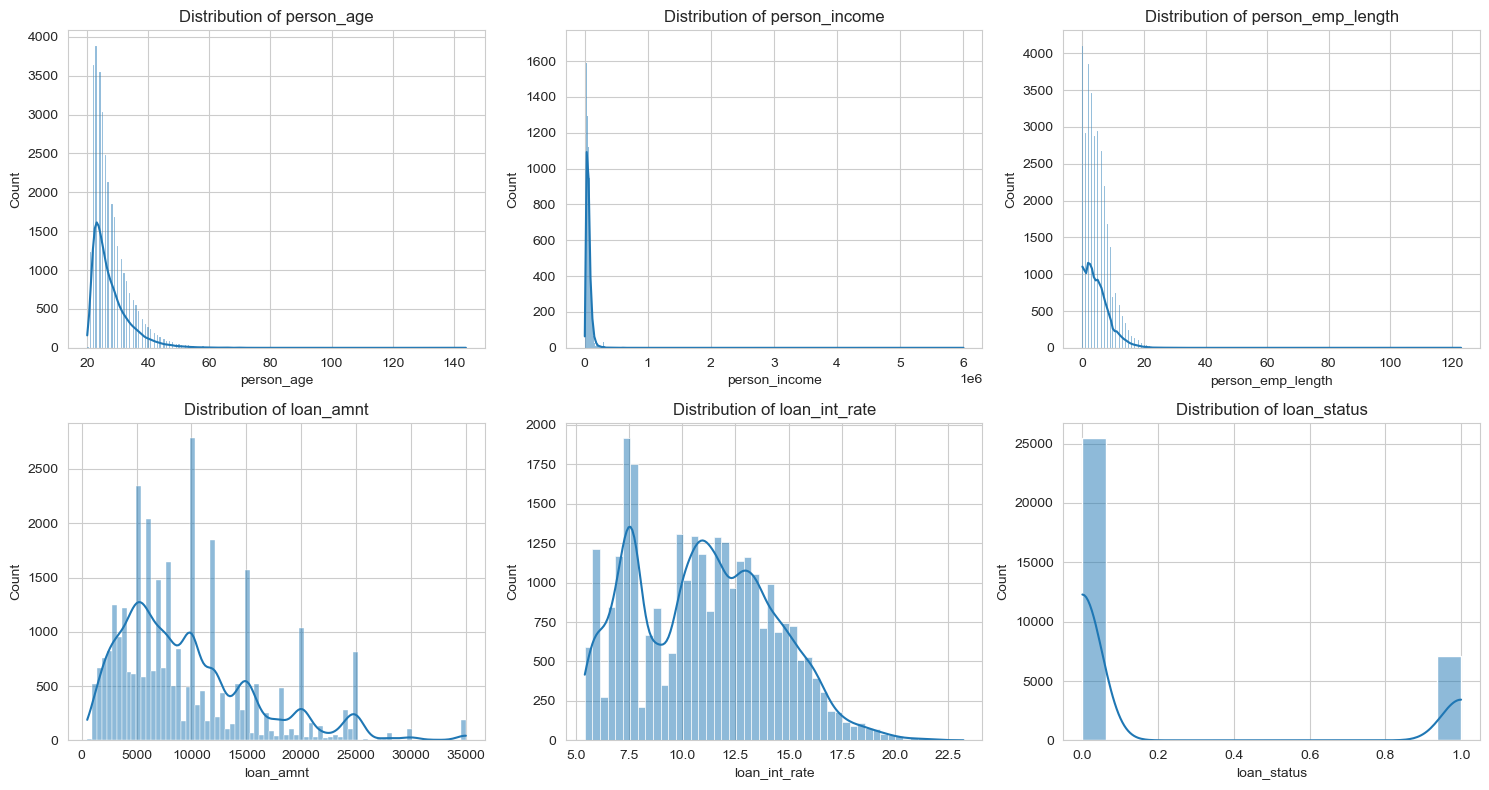